In [193]:
import git
import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from cond_rnn import ConditionalRNN

from sklearn.preprocessing import OneHotEncoder


In [210]:
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [211]:
#import daily covid cases per county
counties_df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
counties_df = counties_df[counties_df['state'].notna()] #drop rows where state is NaN value

#convert fips to integer type
counties_df = counties_df.astype({'fips': 'int64'})

#one hot encode states and add column to dataframe
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
states = np.array(counties_df['state']).reshape(-1, 1)
one_hot_encoder.fit(states)
states_encoded = one_hot_encoder.transform(states).toarray()

counties_df['states_encoded'] = states_encoded.tolist() #add column to dataframe

#convert date to datetime format
counties_df['date'] = pd.to_datetime(counties_df['date'])

In [212]:
counties_df.head()

,fips,date,county,state,cases,deaths,states_encoded
0,53061,2020-01-21,Snohomish,Washington,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,53061,2020-01-22,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,53061,2020-01-23,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,53061,2020-01-24,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,53061,2020-01-25,Snohomish,Washington,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [213]:
#import populations
populations_df = pd.read_csv(f"{homedir}/data/us/demographics/county_populations.csv")
populations_df.rename(columns={'FIPS': 'fips'}, inplace = True)

In [214]:
#import education levels
education_df = pd.read_csv(f"{homedir}/data/us/demographics/education.csv")
education_df = education_df[['FIPS', 'Percent of adults with less than a high school diploma, 2014-18', 'Percent of adults with a high school diploma only, 2014-18', 'Percent of adults completing some college or associate\'s degree, 2014-18', 'Percent of adults with a bachelor\'s degree or higher, 2014-18']]
education_df.rename(columns={'FIPS': 'fips'}, inplace = True)

In [215]:
mobility_df = pd.read_csv(f"{homedir}/data/us/mobility/DL-us-mobility-daterow.csv")
mobility_df = mobility_df[mobility_df['country_code'] == 'US']
mobility_df['date'] = pd.to_datetime(mobility_df['date'])

In [219]:
max(mobility_df['date'])

Timestamp('2020-04-27 00:00:00')

In [218]:
counties_df['date']

0        2020-01-21
1        2020-01-22
2        2020-01-23
3        2020-01-24
4        2020-01-25
            ...    
137483   2020-04-29
137484   2020-04-29
137485   2020-04-29
137486   2020-04-29
137487   2020-04-29
Name: date, Length: 100577, dtype: datetime64[ns]

In [220]:
#merge population/education with original counties data
counties_df = counties_df.merge(populations_df, how = 'left', on = 'fips')
counties_df = counties_df.merge(education_df, how = 'left', on = 'fips')
counties_df = counties_df.merge(mobility_df, how = 'left', on = ['fips', 'date'])

In [234]:
counties_df['m50'] = counties_df['m50'].fillna(0)
counties_df['m50_index'] = counties_df['m50_index'].fillna(0)
counties_df['samples'] = counties_df['samples'].fillna(0)
counties_df = counties_df.drop(['country_code', 'admin_level', 'admin1', 'admin2'], axis = 1)

In [164]:
#preprocessing functions 

def minmax_scaler(x): 
    if max(x) == min(x):
        return x, min(x), max(x)
    else:
        scaled_x = (x - min(x))/(max(x) - min(x))
        return scaled_x, min(x), max(x)
    
def piecewise_log(arr):
    arr[arr == 0] = 1
    return np.log(arr)

In [237]:
def moving_avg_np_array(data, n):
    data_size = len(data)
    avg = np.zeros(data_size)
    moving_sum = 0;
    # for the first  n-1 points, just copy the data over to the
    # moving avg list
    for i in range(n-1):
        avg[i] = data[i]
        moving_sum += data[i] / n
    # for the rest of the points sum over the previous n data points
    #  (including current data point)
    for i in range(n-1, len(data)):
        moving_sum += data[i] / n
        avg[i] = moving_sum
        moving_sum -= data[i - (n-1)] / n
    return avg

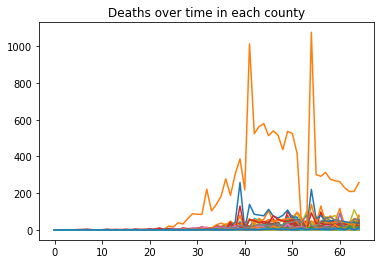

<Figure size 432x288 with 0 Axes>

In [258]:
#initialize lists
inputs_total = []
conditions_total = []

train_inputs = []
train_targets = []
train_conditions = []

test_inputs = []
test_targets = []
test_conditions = []

fips = set(np.array(counties_df['fips'])) #list of unique fips

dateshift = 35 #so here the first 35 days are like all 0 so i shifted the data we're interested in back by 35 days
daterange = pd.date_range(min(counties_df['date'] + datetime.timedelta(days = dateshift)),
                          max(counties_df['date'])).tolist() #range of dates 

split_point = int(len(daterange) * 0.8) #for splitting into training and testing data


fips_fewcases = [] #store fips of cases that are too few to model
fips_manycases = [] #store fips of cases that we are modeling with RNN

for j in range(len(fips)): #iterate through counties 
    i = fips[j]
    if j % 500 == 0:
        print('FIPS processed: ' + str(j) + '/' + str(len(fips)) )
    c_df = counties_df[counties_df['fips'] == i] #county specific dataframe
            
    if max(c_df['deaths']) <= 2: #don't do anything if there are too few cases 
        fips_fewcases.append(i)
    
    elif max(c_df['deaths']) > 2:
        fips_manycases.append(i)
        
        x1 = np.zeros(len(daterange)) #x1 stores cases
        x2 = np.zeros(len(daterange)) #x2 stores deaths
        x3 = np.zeros(len(daterange)) #x3 stores mobility(m50)

        c_daterange = c_df['date'].tolist() #daterange for this specific counties

        for j in range(len(daterange)): #populating time series data for each county
            if daterange[j] in c_daterange: #if there is data for the county for this date, populate x1 and x2
                x1[j] = c_df[c_df['date'] == daterange[j]]['cases'].values[0]
                x2[j] = c_df[c_df['date'] == daterange[j]]['deaths'].values[0]
                x3[j] = c_df[c_df['date'] == daterange[j]]['m50'].values[0]

        #x3 = moving_avg_np_array(x3, 5)
        
        days = np.arange(0, len(x1)) #range of days... to indicate progression of disease?
        
        plt.plot(days, x2) #plot deaths
        
        x = np.stack((piecewise_log(x1), piecewise_log(x2), days, x3), axis = 1) #construct input data
        
        x_train = x[:split_point] #split into training and testing
        x_test = x[split_point:]
        
        inputs_total.append(x)
        
        #construct conditions... one hot encoded states
        state = counties_df[counties_df['fips'] == i]['states_encoded'].values[0]
        pop = counties_df[counties_df['fips'] == i]['total_pop'].values[0]
        pop60 = counties_df[counties_df['fips'] == i]['60plus'].values[0]
        
        edu1 = counties_df[counties_df['fips'] == i]['Percent of adults with less than a high school diploma, 2014-18'].values[0]
        edu2 = counties_df[counties_df['fips'] == i]['Percent of adults with a high school diploma only, 2014-18'].values[0]
        edu3 = counties_df[counties_df['fips'] == i]['Percent of adults completing some college or associate\'s degree, 2014-18'].values[0]
        edu4 = counties_df[counties_df['fips'] == i]['Percent of adults with a bachelor\'s degree or higher, 2014-18'].values[0]
        
        cond_list = state + [np.log(pop), np.log(pop60), edu1/100, edu2/100, edu3/100, edu4/100]
        
        conditions_total.append(np.array(cond_list))
        
        #break up into little batch thingies
        data_gen_train = TimeseriesGenerator(x_train, x_train,
                                       length=10, sampling_rate=1,
                                       batch_size=2)
        
        data_gen_test = TimeseriesGenerator(x_test, x_test,
                                       length=10, sampling_rate=1,
                                       batch_size=2)

        #construct training data
        for k in range(len(data_gen_train)):
            x_b, y_b = data_gen_train[k]
            
            for l in range(len(x_b)):

                x_batch = x_b[l]
                y_batch = y_b[l]
                
                train_inputs.append(x_batch)
                train_targets.append(y_batch)

                #conditions   
                train_conditions.append(np.array(cond_list))
        
        #construct test data
        for k in range(len(data_gen_test)):
            x_b, y_b = data_gen_test[k]
            
            for l in range(len(x_b)):

                x_batch = x_b[l]
                y_batch = y_b[l]
                
                test_inputs.append(x_batch)
                test_targets.append(y_batch)

                #conditions   
                test_conditions.append(np.array(cond_list))

plt.title('Deaths over time in each county')
plt.figure()
                
#make things into arrays
test_inputs = np.array(test_inputs)
test_targets = np.array(test_targets)
test_conditions = np.array(test_conditions)

train_inputs = np.array(train_inputs)
train_targets = np.array(train_targets)
train_conditions = np.array(train_conditions)

inputs_total = np.array(inputs_total)
conditions_total = np.array(conditions_total)

In [260]:
print(train_inputs.shape)
print(train_targets.shape)
print(train_conditions.shape)

(16842, 10, 4)
(16842, 4)
(16842, 58)


In [261]:
print(test_inputs.shape)
print(test_targets.shape)
print(test_conditions.shape)

(1203, 10, 4)
(1203, 4)
(1203, 58)


In [262]:
#if we ever need to invert minmax but i dont think we should use it
def inverse_minmax(scaled_x, min_x, max_x):
    if max(x) == min(x):
        return x, min(x), max(x)
    else:
        unscaled_x = scaled_x * (max_x - min_x) + min_x
        return unscaled_x, min_x, max_x

In [263]:
#construct RNN
class MySimpleModel(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel, self).__init__() #allows you to inherit methods from tf.keras.Model I think
        self.cond = ConditionalRNN(20, cell='LSTM', dtype=tf.float32, return_sequences=True)
        self.cond2 = ConditionalRNN(12, cell='LSTM', dtype=tf.float32)
    
        self.out = tf.keras.layers.Dense(units=4)

    def call(self, inputs, **kwargs):
        x, cond = inputs
        o = self.cond([x, cond])
        o = self.cond2([o, cond])
        o = self.out(o)
        return o

model = MySimpleModel()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.call([train_inputs, train_conditions])
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(x=[train_inputs, train_conditions], y= train_targets, 
                    validation_data=([test_inputs, test_conditions], test_targets), epochs=10)

print('Evaluating model:')
model.evaluate([test_inputs, test_conditions], test_targets)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 16842 s

26.214424647000662

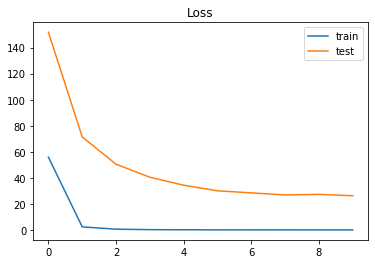

In [248]:
#plot loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

In [249]:
y = model.predict([train_inputs, train_conditions])
print(train_inputs.shape)
print(y.shape)
print(train_targets.shape)

(16842, 10, 4)
(16842, 4)
(16842, 4)


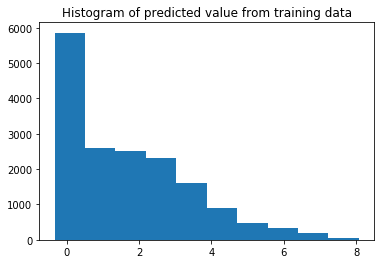

In [250]:
#plot the predicted output to get an idea of what kind of values the model is producing
plt.hist(y[:, 0])
plt.title('Histogram of predicted value from training data')
plt.show()

In [251]:
#function for generating predictions T timesteps into the future 
#for county with index k

def generate_predictions(model, inputs_total, conditions_total, T, k):
    
    inputs = inputs_total[k]
    conditions = conditions_total
    
    y_predict = model.predict([[inputs], [conditions[k, :]]])
    prediction = np.array([y_predict])
    inputs = np.append(inputs, np.array(y_predict), axis = 0)
    
    print('Generating predictions:')
    for i in range(T):
        
        y_predict = model.predict([[inputs], [conditions[k, :]]])
        inputs = np.append(inputs, np.array(y_predict), axis = 0)
        prediction = np.append(prediction, [y_predict], axis = 0)
        
    return inputs, prediction 

Generating predictions:


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

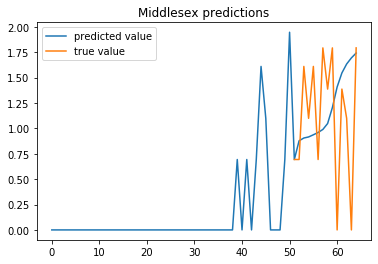

In [254]:
#ind = 349
ind = 31

county_title = counties_df[counties_df['fips'] == fips_manycases[ind]]['county'].values[0]

I, P = generate_predictions(model, inputs_total[:, :split_point, :], conditions_total, 12, ind)

plt.plot(range(len(I)), I[:, 1], label = 'predicted value')
plt.plot(range(split_point - 1, len(I)), inputs_total[ind, split_point - 1:, 1], label = 'true value')
plt.title(county_title + ' predictions')
plt.legend()
plt.figure

Generating predictions:


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

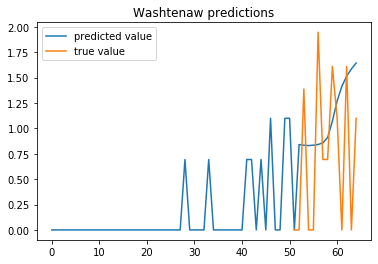

In [257]:
ind = 100

county_title = counties_df[counties_df['fips'] == fips_manycases[ind]]['county'].values[0]

I, P = generate_predictions(model, inputs_total[:, :split_point, :], conditions_total, 12, ind)

plt.plot(range(len(I)), I[:, 1], label = 'predicted value')
plt.plot(range(split_point - 1, len(I)), inputs_total[ind, split_point - 1:, 1], label = 'true value')
plt.title(county_title + ' predictions')
plt.legend()
plt.figure